# Algorithm for leaf growth

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import sympy
from scipy.optimize import brentq
from scipy.interpolate import CubicSpline

from openalea.archicrop.simulation import retrieve_stics_dynamics_from_file
from openalea.archicrop.plant_shape import bell_shaped_dist

from ipywidgets import interact, interactive, IntSlider, FloatSlider, fixed, Play, HBox, VBox, jslink

Import test STICS data

In [2]:
# Data points
stics_output_file = 'mod_ssorghum.sti'
sowing_density = 10
inter_row = 0.4
stics_output_data = retrieve_stics_dynamics_from_file(stics_output_file, sowing_density)
time = [value["Thermal time"] for value in stics_output_data.values()]
LA_stics = [value["Plant leaf area"] for value in stics_output_data.values()]
height_stics = [value["Plant height"] for value in stics_output_data.values()]
par_stics = [value["Absorbed PAR"] for value in stics_output_data.values()]
height_potential_plant = max(height_stics)

In [3]:
# Create the cubic spline interpolator
cs = CubicSpline(time, LA_stics)

In [4]:
# Compute the first derivative
cs_derivative = cs.derivative()

# Evaluate the derivative at specific points
x_dense = np.arange(min(time), max(time), 1)  # Fine grid for plotting
y_dense = cs(x_dense)                       # Interpolated values
dy_dense = cs_derivative(x_dense)           # Derivative values

## $H_0$: Linear leaf area growth

Inputs:
- number of phytomers $N_{phy}$
- development parameters: phyllochron $\phi$, ligulochron $lig$
- leaf area distribution in plant: $leaf\_area = f(rank, params)$ with $params = (r_{max}, skew)$
- maximal plant leaf area $S_{max}$

Steps:
- Define number of phytomers

In [5]:
nb_phy = 20

- Define leaf development from appearance to ligulation 

In [36]:
def dev(phyllochron, ligulochron, nb_phy):

    for i in range(1,nb_phy+1):
        start = (i-1) * phyllochron
        end = start + ligulochron
        plt.plot(np.linspace(start, end, 2), [i,i], color="g")
    
    # plt.fill_between([end/2.1,end/2.1+25], 0, nb_phy, color="grey", alpha=0.4)
    plt.xlabel("Thermal time (°C.d)")
    plt.ylabel("Phytomer rank")
    plt.xlim(0,end)
    plt.show()

interact(dev, phyllochron=IntSlider(min=30,max=60,step=5,value=45), ligulochron=IntSlider(min=50,max=100,step=5,value=80), nb_phy=fixed(nb_phy))

interactive(children=(IntSlider(value=45, description='phyllochron', max=60, min=30, step=5), IntSlider(value=…

<function __main__.dev(phyllochron, ligulochron, nb_phy)>

- Define allometric law for relative leaf area as a function of phytomer rank

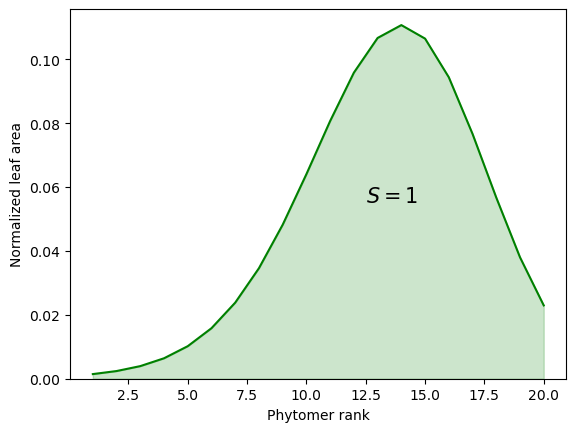

In [9]:
rmax = 0.7
skew = 0.0005
Smax = 1

leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

plt.plot(range(1,len(leaf_areas)+1), leaf_areas, color="g")
plt.fill_between(range(1,len(leaf_areas)+1), [0]*len(leaf_areas), leaf_areas, color="g", alpha=0.2)
plt.ylim(0,max(leaf_areas)+0.005)
plt.xlabel("Phytomer rank")
plt.ylabel("Normalized leaf area")
plt.text(rmax*nb_phy-1.5, max(leaf_areas)/2, '$S = 1$', fontsize = 15)
plt.show()

- Scale the leaf areas according to the given maximal plant leaf area $S_{max}$

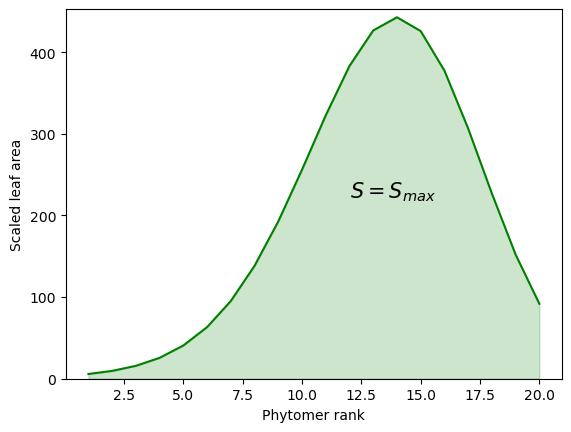

In [10]:
Smax = 4000
scaled_leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

plt.plot(range(1,len(scaled_leaf_areas)+1), scaled_leaf_areas, color="g")
plt.fill_between(range(1,len(scaled_leaf_areas)+1), [0]*len(scaled_leaf_areas), scaled_leaf_areas, color="g", alpha=0.2)
plt.ylim(0,max(scaled_leaf_areas)+10)
plt.xlabel("Phytomer rank")
plt.ylabel("Scaled leaf area")
plt.text(rmax*nb_phy-2, max(scaled_leaf_areas)/2, '$S = S_{max}$', fontsize = 15)
plt.show()

- At each time step, knowing H0, add the leaf area increment of each growing organ to the sum of appeared leaf area. 

In [11]:
def linear_leaf_growth(phyllochron, ligulochron, nb_phy):

    fig, ax1 = plt.subplots()

    starts = []
    ends = []

    for i in range(nb_phy):
        start = i * phyllochron
        end = start + ligulochron
        starts.append(start)
        ends.append(end)
        ax1.plot(np.linspace(start, end, 2), [0,scaled_leaf_areas[i]], color="g")
        ax1.text(end-4, scaled_leaf_areas[i]+3, f'{i+1}', fontsize = 10)

    S = []
    
    for t in range(max(ends)):
        sum_temp = 0
        for i,(s,e) in enumerate(zip(starts,ends)):
            if s <= t < e:
                sum_temp += (t-s)/(e-s) * scaled_leaf_areas[i]
            elif t >= e:
                sum_temp += scaled_leaf_areas[i]
        S.append(sum_temp)                
    
   
    ax1.set_xlabel("Thermal time (°C.d)")
    ax1.set_ylabel("Leaf area (cm²)")
    ax1.fill_between([end/1.95,end/1.95+25], 0, max(scaled_leaf_areas), color="grey", alpha=0.4)
             
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    
    ax2.set_ylabel("Plant leaf area (cm²)")
    ax2.fill_between(range(len(S)), [0]*len(S), S, color="g", alpha=0.2)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

interact(linear_leaf_growth, phyllochron=IntSlider(min=30,max=60,step=5,value=45), ligulochron=IntSlider(min=50,max=100,step=5,value=80), nb_phy=fixed(nb_phy))

interactive(children=(IntSlider(value=45, description='phyllochron', max=60, min=30, step=5), IntSlider(value=…

<function __main__.linear_leaf_growth(phyllochron, ligulochron)>

Outputs:
- Plant leaf area growth dynamics $\forall t \in [0,T], S_{plant}(t) = \sum_{i=1}^{N_{phy, appeared}} s_i(t)$

_______________________________________________________________________________________________________________

## $H_1$: given $S_{constraint}=f(t)$, $\forall t \in [0,T]$, $S_{potential}(t) \geq S_{constraint}(t)$

Inputs:
- number of phytomers $N_{phy}$
- development parameters: phyllochron $\phi$, ligulochron $lig$
- leaf area distribution in plant: $leaf\_area = f(rank, params)$ with $params = (r_{max}, skew)$ 
- plant leaf area growth dynamics $S_{constraint}=f(t)$, such that maximal plant leaf area $S_{max} = max(S_{constraint}(t))$

Steps:
- Define number of phytomers

In [12]:
nb_phy = 20

- Define leaf development from appearance to ligulation 

In [13]:
def dev(phyllochron, ligulochron, nb_phy):

    starts = []
    ends = []
    
    for i in range(1,nb_phy+1):
        start = (i-1) * phyllochron
        end = start + ligulochron
        starts.append(start)
        ends.append(end)
        plt.plot(np.linspace(start, end, 2), [i,i], color="g")

    nb_growing = []
    for t in range(max(ends)):
        nb_growing_temp = 0
        for i,(s,e) in enumerate(zip(starts,ends)):
            if s <= t < e:
                nb_growing_temp += 1
        nb_growing.append(nb_growing_temp) 
        
    plt.fill_between(range(len(nb_growing)), [0]*len(nb_growing), nb_growing, color="g", alpha=0.2)
    plt.xlabel("Thermal time (°C.d)")
    plt.ylabel("Phytomer rank")
    plt.xlim(0,end)
    plt.show()

interact(dev, phyllochron=IntSlider(min=30,max=60,step=5,value=45), ligulochron=IntSlider(min=50,max=100,step=5,value=80), nb_phy=fixed(nb_phy))

interactive(children=(IntSlider(value=45, description='phyllochron', max=60, min=30, step=5), IntSlider(value=…

<function __main__.dev(phyllochron, ligulochron)>

- Define allometric law for relative leaf area as a function of phytomer rank

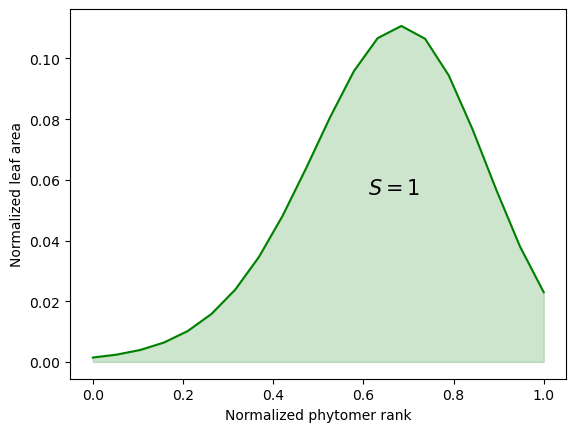

In [14]:
rmax = 0.7
skew = 0.0005
Smax = 1

leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

plt.plot(np.linspace(0,1,20), leaf_areas, color="g")
plt.plot()
plt.fill_between(np.linspace(0,1,20), [0]*len(leaf_areas), leaf_areas, color="g", alpha=0.2)
# plt.ylim(0,max(leaf_areas)+0.005)
plt.xlabel("Normalized phytomer rank")
plt.ylabel("Normalized leaf area")
plt.text(rmax-0.09, max(leaf_areas)/2, '$S = 1$', fontsize = 15)
plt.show()

- Scale the leaf areas according to the given maximal plant leaf area $S_{max}$, to obtain 
$s_{i, potential}$ for each leaf $i$.

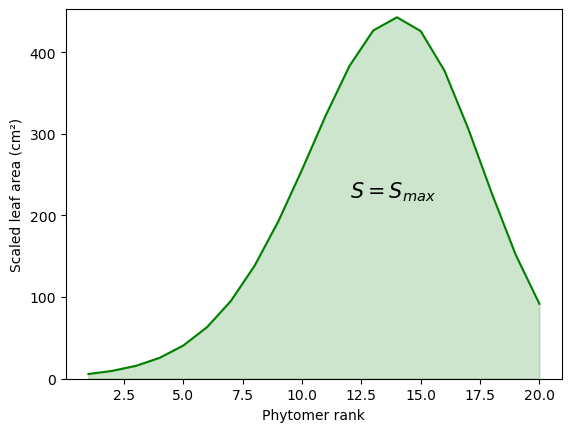

In [15]:
Smax = 4000
scaled_leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

plt.plot(range(1,len(scaled_leaf_areas)+1), scaled_leaf_areas, color="g")
plt.fill_between(range(1,len(scaled_leaf_areas)+1), [0]*len(scaled_leaf_areas), scaled_leaf_areas, color="g", alpha=0.2)
plt.ylim(0,max(scaled_leaf_areas)+10)
plt.xlabel("Phytomer rank")
plt.ylabel("Scaled leaf area (cm²)")
plt.text(rmax*nb_phy-2, max(scaled_leaf_areas)/2, '$S = S_{max}$', fontsize = 15)
plt.show()

At each time step, distribute the increment of given plant leaf area $\frac{dS_{constraint}(t)}{dt}$ among $g$ growing leaves.

Let’s consider $F(\alpha_1 x_1,…,\alpha_g x_g) = \sum_{i=1}^{g} \alpha_i x_i$, where $\sum_{i=1}^{g} \alpha_i = 1$ and $x_i = ds_i$ or $dh_i$

 


$H_{1.0}$ : Equal distribution of the gain among all growing vegetative organs 

For a growing leaf $i$ among $g$ growing leaves in a plant, given a plant leaf area increment $dS(t)$ for the plant at time $t$, the leaf area increment $ds_i(t)$ is:   
$ds_i(t)=\frac{dS(t)}{g}$ with $\alpha_1=\dots=\alpha_g=\frac{1}{g}$
 

In [16]:
def equal_distribution(ds, g):
    return [ds/g for i in range(g)]

$H_{1.1}$: Demand of leaf area proportionnal to final area

For a growing leaf $i$ of potential leaf area $S_{i}^{max}$ among $g$ growing leaves in a plant, given a plant leaf area increment $dS(t)$ for the plant at time $t$, the leaf area increment $ds_i(t)$ is:   
$ds_i(t)=\alpha_i \times  dS(t) $ such that $\alpha_{i} = \frac{S_{i}^{max}}{\sum^{g}_{j=1} S_{j}^{max}} $ and $\sum^{g}_{i=1} \alpha_{i} = 1$

In [20]:
def demand_related_distribution(ds, potential_areas_growing_leaves):
    sum_areas_growing_leaves = sum(potential_areas_growing_leaves)
    return [ds*pi/sum_areas_growing_leaves for pi in potential_areas_growing_leaves]

ds = 10
potential_areas_growing_leaves = [5,8,6]
print(demand_related_distribution(ds, potential_areas_growing_leaves))

[2.6315789473684212, 4.2105263157894735, 3.1578947368421053]


$H_{1.2}$: Partition of unity with Bernstein polynomials of degree $g-1$: 

$\alpha_{i, g−1}(x)= \frac{(g−1)!}{i!(g−1−i)!} x^i (1−x)^{g−1−i}$ such that $\sum^{g−1}_{i=0} \alpha_{i, g−1} (x) = 1, \forall x \in [0,1]$

in progress

In [21]:
def bernstein_polynomials(n, x): # n = g-1
    """
    Compute Bernstein polynomials of degree n at point x (in [0,1]).
    Returns a list of coefficients for partition of unity.
    """
    bernstein = []
    for i in range(n + 1):
        bin_coeff = math.comb(n, i)  # Binomial coefficient
        bernstein.append(bin_coeff * (x**i) * ((1 - x)**(n - i)))
    return bernstein

In [22]:
def partition_of_unity(x_fixed):
    """
    
    """
    # print("Bernstein Polynomials:")
    g_range = [2,3,4]
    x_range = np.arange(0,1.1,0.1)
    
    fig, axes = plt.subplots(1,len(g_range), figsize=(12, 4))
    
    for g in g_range:
        # print(f"For {g} growing organs:")
        n = g - 1
        values = {i: [] for i in range(1, g + 1)}
        
        for x in x_range:
            bernstein = bernstein_polynomials(n, x)
            for j,b in enumerate(bernstein):
                values[j+1].append(round(b,5))
            # print(f"    - at point {round(x,1)}", bernstein)
    
        for k,v in values.items():
            axes[g-2].plot(x_range, v, color='green')
            axes[g-2].text(x_fixed, v[int(x_fixed*10)], f"{k}")
        axes[g-2].set_title(f"For {g} growing organs")
        axes[g-2].plot([x_fixed]*2,[0,1], linestyle='--', color='gray')
    
    plt.suptitle("Partition of unity with Bernstein polynomials")
    plt.subplots_adjust(wspace=0.2)
    plt.show()

interact(partition_of_unity, x_fixed=FloatSlider(min=0.0,max=1.0,step=0.1,value=0.3))

interactive(children=(FloatSlider(value=0.3, description='x_fixed', max=1.0), Output()), _dom_classes=('widget…

<function __main__.partition_of_unity(x_fixed)>

## From leaf area increment to leaf length increment

Leaf shape

In [23]:
wl = 0.12

In [24]:
def sr_prevot(nb_segment=100, alpha=-2.3):
    beta = -2 * (alpha + np.sqrt(-alpha))
    gamma = 2 * np.sqrt(-alpha) + alpha
    s = np.linspace(0, 1, nb_segment + 1)
    r = alpha * s**2 + beta * s + gamma
    return s, r

def leaf_elongation(l, dl):
    sp, rp = sr_prevot()
    ss = int(l*100)
    dss = int(dl*100)
    plt.plot(sp, rp, color="g")
    plt.plot(sp, -rp, color="g")
    plt.plot(sp,[0]*len(rp), color="g", linestyle="--")
    plt.fill_between(sp[-ss:], -rp[-ss:], rp[-ss:], color="g", alpha=0.2)
    plt.fill_between(sp[-(ss+dss):], -rp[-(ss+dss):], rp[-(ss+dss):], color="g", alpha=0.2)
    plt.text(max(0,1-(l+dl))+0.03, 0.1, f"dl = {round(min(dl,1.0-l),5)}")
    plt.xlabel("Normalized leaf length")
    plt.ylabel("Normalized leaf width")
    plt.show()

interact(leaf_elongation, l=FloatSlider(min=0.001,max=1.001,step=0.05,value=0.3), dl=FloatSlider(min=0.0,max=1.0,step=0.05,value=0.1))

interactive(children=(FloatSlider(value=0.3, description='l', max=1.001, min=0.001, step=0.05), FloatSlider(va…

<function __main__.leaf_elongation(l, dl)>

Analytical expression of leaf area as a function of midrib length from tip to base

In [38]:
# Define the variable and parameters
s = sympy.symbols('l')
L, wl, alpha = sympy.symbols('L, wl, alpha') 

# Define the scaled leaf shape function with parameters
# alpha = -2.3
beta = -2 * (alpha + math.sqrt(-alpha))
gamma = 2 * math.sqrt(-alpha) + alpha
r = alpha * s**2 + beta * s + gamma

# Reflect the function to the axis x=0.5 
reflected_r = r.subs(s, -s+L).simplify()

# Find the indefinite integral (primitive)
primitive_f = sympy.integrate(reflected_r, s)

print(2*primitive_f)

TypeError: Cannot convert expression to float

In [26]:
def leaf_area(l, L=1, wl=1):
    return 3.03*l**2*wl - 1.53*l**3*wl/L

def d_leaf_area(l, dl, L=1, wl=1):
    return leaf_area(l+dl,L,wl) - leaf_area(l,L,wl)

def d_leaf_area_norm(l, dl, L=1, wl=1):
    return (leaf_area(l+dl,L,wl) - leaf_area(l,L,wl)) / leaf_area(L,L,wl)

print("Total leaf area :", leaf_area(1, wl=0.12))
print("Delta leaf area in l=[0.5,0.6]", d_leaf_area(0.5, 0.1, wl=0.12))

Total leaf area : 0.18
Delta leaf area in l=[0.5,0.6] 0.0232884


Discretizing leaf area to get dS-to-dl correspondance easily

3527.999999999751


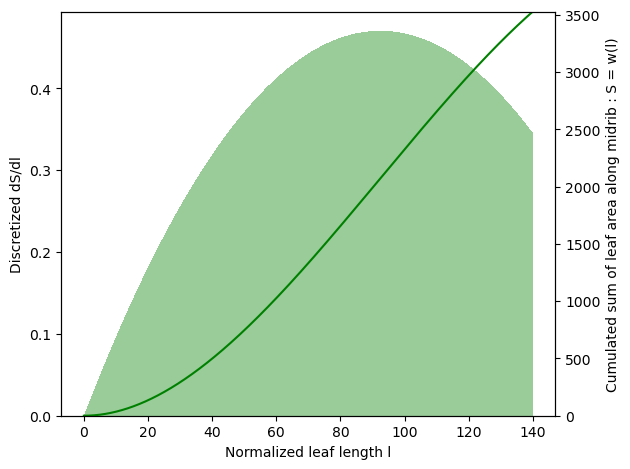

In [27]:
L = 140
wl = 0.12
dl = 0.0001*L 
l_values = np.arange(0, L, dl)  

ds_list = []
for l in l_values:
    ds_list.append(d_leaf_area(l,dl,L,wl))
print(np.sum(ds_list))

fig, ax1 = plt.subplots()

ax1.bar(l_values, ds_list, width=dl, color="g", alpha=0.4)
ax1.set_xlabel("Normalized leaf length l")
ax1.set_ylabel("Discretized dS/dl")
         
ax2 = ax1.twinx()  

ax2.plot(l_values, np.cumsum(ds_list), color="g")
ax2.set_ylabel("Cumulated sum of leaf area along midrib : S = w(l)")
ax2.set_ylim(0,np.sum(ds_list))

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

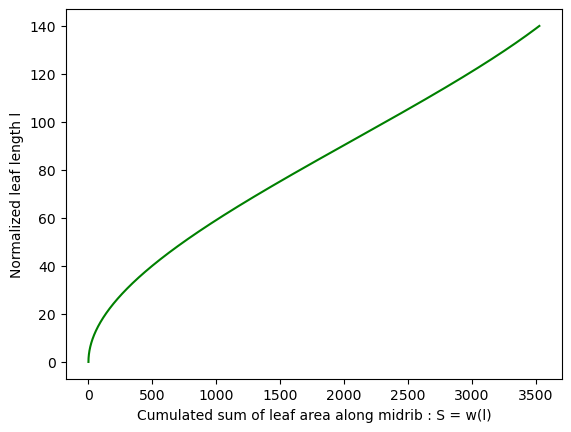

In [35]:
plt.plot(np.cumsum(ds_list), l_values, color="g")
plt.xlabel("Cumulated sum of leaf area along midrib : S = w(l)")
plt.ylabel("Normalized leaf length l")
plt.show()

In [28]:
corres_dl_dS = {}
for i,dl in enumerate(l_values):
    corres_dl_dS[dl] = np.cumsum(ds_list)[i]
# print(corres_dl_dS)

In [29]:
l = 0
dS_input = 0.02

def search_new_dl(d, l, dS_input, L=1):
    found_start = False  
    first = True
    key_prev = None
    value_prev = None
    for key, value in d.items():
        if key >= l:
            found_start = True  
            if first:
                S_start = value
                key_prev, value_prev = key, value
                first = False
        if found_start:
            # print(key, value-S_start)
            if value-S_start >= dS_input:  
                return key_prev, value_prev 
            else:
                key_prev, value_prev = key, value
    return L, value  # if no match is found --> finished

result = search_new_dl(corres_dl_dS, l, dS_input)
print("New l = ", round(result[0],4))

New l =  0.21


Whole process for one leaf

In [30]:
l = 0
l_list = [l]
dS_new_list = [0]
for dS_input in dy_dense:
    l, dS_new = search_new_dl(corres_dl_dS, l, dS_input, L=3000)
    l_list.append(l)
    dS_new_list.append(dS_new)

# plt.plot(l_list, dS_new_list, color="g")
# plt.show()

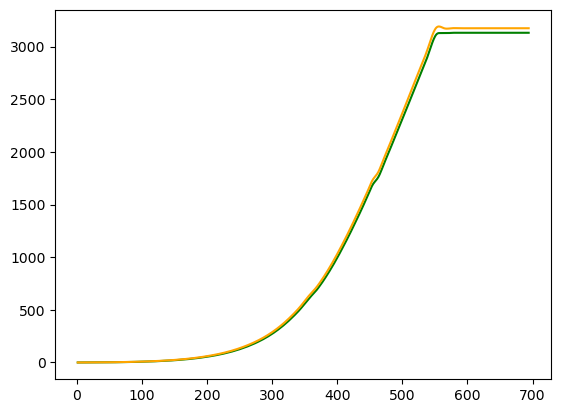

In [31]:
plt.plot(x_dense, dS_new_list[:-1], color="g")
plt.plot(x_dense, y_dense, color="orange")
plt.show()

For several leaves

In [32]:
# dev

# for loop
    # distribute among growing leaves
    # for each growing leaf
        # translate dS in dl (check potential size)

# compare plant profiles of potential and constraint

- Analytical resolution of dl (in progress)

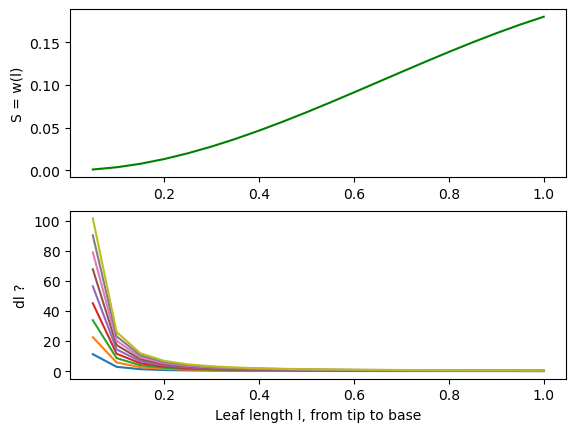

l : 0.05 dl : 101.574
l : 0.1 dl : 26.069
l : 0.15 dl : 11.903
l : 0.2 dl : 6.883
l : 0.25 dl : 4.533
l : 0.3 dl : 3.241
l : 0.35 dl : 2.454
l : 0.4 dl : 1.939
l : 0.45 dl : 1.582
l : 0.5 dl : 1.325
l : 0.55 dl : 1.133
l : 0.6 dl : 0.986
l : 0.65 dl : 0.872
l : 0.7 dl : 0.781
l : 0.75 dl : 0.708
l : 0.8 dl : 0.649
l : 0.85 dl : 0.6
l : 0.9 dl : 0.56
l : 0.95 dl : 0.527
l : 1.0 dl : 0.5


In [33]:
L = 1
dS_range = np.arange(0.01,0.1,0.01)
x = np.arange(0.05,1.05*L,0.05)

fig, ax = plt.subplots(2,1)

ax[0].plot([0]+x, [3.03*l**2*wl - 1.53*l**3*wl/L for l in [0]+x], color="g")
ax[0].set_ylabel("S = w(l)")
for dS in dS_range:
    ax[1].plot(x, [dS/(3.03*l**2*wl - 1.53*l**3*wl/L) for l in x])
ax[1].set_ylabel("dl ?")
ax[1].set_xlabel("Leaf length l, from tip to base")
plt.show()

for l in x:
    print("l :", round(l,3), "dl :", round(dS/(3.03*l**2*wl - 1.53*l**3*wl/L),3))